# Perform power flow calculations with pandapower

The test bench consists of two nodes and a transformer of type [SGB Smit DTTH 630 kVA](https://www.sgb-smit.com/fileadmin/user_upload/Downloads/Broschueren/Cast_Resin_Transformers/GT_Technik_UniQ_D.pdf)
with an artificial tap changer (+/- 10 tap positions with 2.5 % per step) at the transformer's low voltage side.

Sweep through all tap positions as well as active power consumptions and examine the results.
The active power is varied within -400 kW to 400 kW.
As transformer model, the commonly used pi equivalent circuit is used.

### Perform power flow calculations

In [1]:
from calculation.pandapower.TestGrid import TapSide, TransformerModel
from calculation.pandapower.TransformerTestBench import TransformerTestBench

# Set up the test bench
test_bench = TransformerTestBench()

# Define parameters
tap_min = -10
tap_max = 10
p_min = -1
p_max = 1
p_step_size = 0.1

# Perform calculations and get results
results = test_bench.calculate(tap_min=tap_min, tap_max=tap_max, p_min=p_min, p_max=p_max, p_nom_mw=0.4,
                               p_step_size=p_step_size, v_ref_kv=0.4,
                               s_ref_mva=0.4, tap_side=TapSide.LV, transformer_model=TransformerModel.PI)

INFO:root:Starting to calculate grid with pandapower. Parameters: tap = -10...10, p = (-1.00...1.00)*0.40 MW, reference = 0.40 MVA @ 0.40 kV, tap side = TapSide.LV
INFO:root:Preparing the general information


### Plot the results

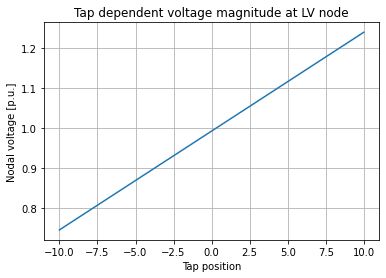

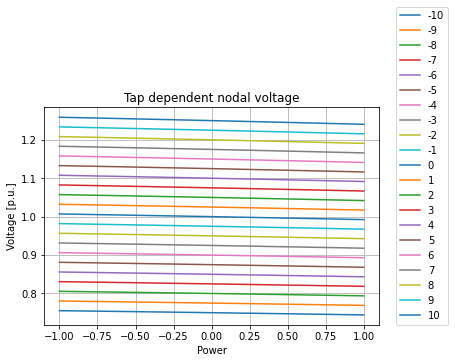

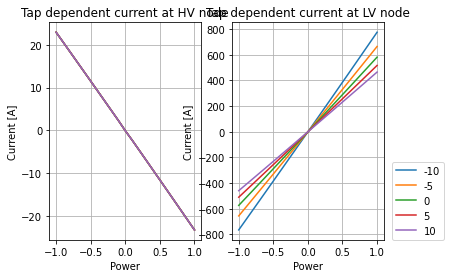

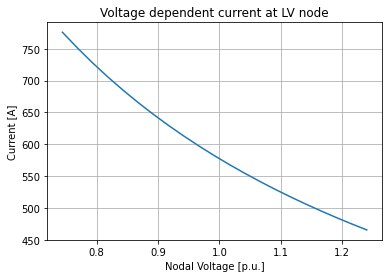

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define abscissa range (active power)
x = np.arange(p_min, p_max + p_step_size, p_step_size)

# Plot the tap dependent nodal voltage for a fully loaded transformer
fig_tap_voltage_full, ax_tap_voltage_full = plt.subplots()
tap_range = range(tap_min, tap_max + 1)
ord_tap_voltage_full= []
for tap_pos in tap_range:
    ord_tap_voltage_full = ord_tap_voltage_full + list(map(lambda tpl: tpl[1].v_pu, filter(lambda value: abs(value[0] - 1.0) < 1E-9, results[str(tap_pos)])))
ax_tap_voltage_full.plot(np.array(tap_range), np.array(ord_tap_voltage_full))
ax_tap_voltage_full.grid()
ax_tap_voltage_full.set(xlabel='Tap position', ylabel='Nodal voltage [p.u.]',
                       title='Tap dependent voltage magnitude at LV node')

# Plot the tap dependent voltage for each tap position
fig_tap_voltage, ax = plt.subplots()
for tap_pos in range(tap_min, tap_max + 1):
    # Extract all voltage magnitudes from results
    v = list(map(lambda value: value[1].v_pu, results[str(tap_pos)]))
    y = np.array(v)
    ax.plot(x, y, label=str(tap_pos))

ax.set(xlabel='Power', ylabel='Voltage [p.u.]',
       title='Tap dependent nodal voltage')
ax.grid()
ax.legend(loc=(1.05, 0))

# Plot the tap dependent port currents
fig_tap_current, (ax_tap_current_hv, ax_tap_current_lv) = plt.subplots(1, 2)
for tap_pos in [-10, -5, 0, 5, 10]:
    # Extract port currents from results
    i_hv = list(map(lambda value: value[1].i_mag_hv_a if value[1].i_ang_hv_degree > 90.0 or value[
        1].i_ang_hv_degree < -90.0 else -value[1].i_mag_hv_a, results[str(tap_pos)]))
    i_lv = list(map(lambda value: value[1].i_mag_lv_a if value[1].i_ang_lv_degree > 90.0 or value[
        1].i_ang_lv_degree < -90.0 else -value[1].i_mag_lv_a, results[str(tap_pos)]))
    ax_tap_current_hv.plot(x, np.array(i_hv))
    ax_tap_current_lv.plot(x, np.array(i_lv), label=str(tap_pos))

ax_tap_current_hv.set(xlabel='Power', ylabel='Current [A]',
                      title='Tap dependent current at HV node')
ax_tap_current_hv.grid()
ax_tap_current_lv.set(xlabel='Power', ylabel='Current [A]',
                      title='Tap dependent current at LV node')
ax_tap_current_lv.grid()
ax_tap_current_lv.legend(loc=(1.05, 0))

# Plot the voltage dependent port current at low voltage node
fig_voltage_current, ax_voltage_current = plt.subplots()
abscissa = []
ordinate = []
for tap_pos in range(tap_min, tap_max + 1):
    relevant_result = map(lambda tpl: tpl[1], filter(lambda value: abs(value[0] - 1.0) < 1E-9, results[str(tap_pos)]))
    for result in relevant_result:
        abscissa.append(result.v_pu)
        ordinate.append(result.i_mag_lv_a)
ax_voltage_current.plot(np.array(abscissa), np.array(ordinate))
ax_voltage_current.grid()
ax_voltage_current.set(xlabel='Nodal Voltage [p.u.]', ylabel='Current [A]',
                       title='Voltage dependent current at LV node')

plt.show()

### Observations and conclusions
-   The low voltage magnitude raises linearly with increasing tap position: This meets my expectations
-   The low voltage magnitude decreases with increasing power consumption: This meets my expectations
-   The port current at the high voltage node is linear in increased power
    -   As the upper port voltage is fixed, this meets the expectations
-   The port current at the high voltage node is independent of the tap position
    -   As the upper port voltage is fixed, the same power needs the same current, irrespective of the tap position
-   The port currents on both signs have inverse signs. This meets my expectations
-   The smaller the lower voltage side's voltage magnitude, the higher the current
    -   This meets my expectations
    -   It exhibits a nearly quadratic dependency (by eye) with the voltage magnitude